In [1]:
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import wandb

import tarfile
import pickle
from collections import Counter

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# import requests

# import urllib

# testfile = urllib.URLopener()
# testfile.retrieve("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", "cifar-100-python.tar.gz")

In [3]:

with tarfile.open("cifar-100-python.tar.gz", 'r|gz') as f:
        f.extractall(path="./")
        f.close()

# Extract cifar-100-python.tar.gz to separate data

In [5]:
data = pickle.load(open(os.path.join("cifar-100-python", "train"), 'rb'), encoding='latin1')
X_train_np = data['data']
y_train_np = np.asarray(data['fine_labels'], np.int8)

data = pickle.load(open(os.path.join('cifar-100-python', 'test'), 'rb'), encoding='latin1')
X_test_np = data['data']
y_test_np = np.asarray(data['fine_labels'], np.int8)

In [6]:
# reshape
X_train_np = X_train_np.reshape(-1, 3, 32, 32)
X_test_np = X_test_np.reshape(-1, 3, 32, 32)


In [7]:
# X_train_np.shape
# sns.countplot(y_train_np)

x_max,y_max = 3,3
offset = 0

# f, axarr = plt.subplots(y_max,x_max)
# for y in range(y_max):
#     for x in range(x_max):
#         axarr[y,x].imshow(X_train_np[y*y_max+x+offset])
# print(y_train[i])
# plt.imshow(np.rollaxis(X_train[i], 0, 3))

In [7]:
mean = X_train_np.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
std = X_train_np.std(axis=(0,1,2), keepdims=True).astype(np.float32)

X_train_np = (X_train_np - mean) / std
X_test_np = (X_test_np - mean) / std

#TODO POROVNAT S -MEAN)/MAX

In [8]:
def train_test_split_v2(X_train,y_train,test_size,random_state=None,sample_limit=None):
    total_count = len(X_train)
    if sample_limit:
        _, X_train, _, y_train = train_test_split(X_train, y_train, test_size=1/(total_count/sample_limit), random_state=random_state)
    return train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

In [9]:
X_train,X_valid,y_train,y_valid= train_test_split_v2(X_train_np, y_train_np,sample_limit=None, test_size=1/6, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_train.shape[0]+X_valid.shape[0])


(41666, 3, 32, 32)
(8334, 3, 32, 32)
50000


In [10]:
class CIFAR(Dataset):
    def __init__(self, X,y,transform=None):
        self.X=X
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        image = np.rollaxis(self.X[index],0,3)
        label = self.y[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape:  torch.Size([256, 3, 32, 32])
labels shape:  torch.Size([256])


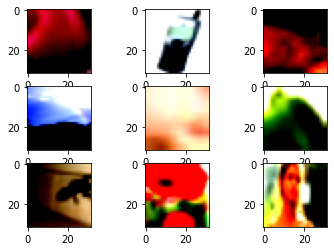

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(32)
])

train_data = CIFAR(X_train,y_train, transform=transform)
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=256)
valid_loader = DataLoader(dataset=valid_data,batch_size=256)


dataiter=iter(train_loader)
images, labels = dataiter.next()

print('images shape: ', images.size())
print('labels shape: ', labels.size())


x_max,y_max = 3,3
offset = 0

f, axarr = plt.subplots(y_max,x_max)
for y in range(y_max):
    for x in range(x_max):
        axarr[y,x].imshow(images[y*y_max+x].permute(1,2,0))

In [16]:
vgg11 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Dropout(),
            nn.ReLU(True),
        )


vgg11_bn = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )

# vgg13_bn = nn.Sequential(
#     nn.Conv2d(3,64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(64,64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(64,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(128,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(128,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(256,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2)
# )

# vgg16_bn = nn.Sequential(
#     nn.Conv2d(3,64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(64,64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(64,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(128,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(128,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(256,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2)
# )

# vgg19_bn = nn.Sequential(
#     nn.Conv2d(3,64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(64,64, kernel_size=3, padding=1),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(64,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(128,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(128,128, kernel_size=3, padding=1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(128,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(256,256, kernel_size=3, padding=1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(256,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     # ---
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(512,512, kernel_size=3, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True)
# )

In [12]:
class SimpleNet(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(8192,),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class Net(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(Net, self).__init__()
        self.features = vgg11_bn
        self.classifier = nn.Sequential(
            nn.Linear(512,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:

learning_rate=1e-4
betas = (0.9,0.999)
batch_size = 256
sample_limit = 6000
epochs = 50

n_epochs_stop = 6
epochs_no_improve = 0
early_stop = False

In [14]:
#model saving

def save_model(epoch, model, optimizer, train_loss, valid_loss, accuracy):
    PATH = 'current_state.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'accuracy' : accuracy
    }, PATH)

In [17]:
run = wandb.init(project='Zadanie2-CIFAR', entity='xpetricko')
run.name = f"13run-{epochs}e-{batch_size}bs-vgg11_bn"


config = wandb.config
config.learning_rate = learning_rate
config.sample_limit=sample_limit
config.batch_size=batch_size
config.epochs_with_no_improve =  6
config.notes='AdamW optimizer + adjusting lr for 0.9 in each epoch'


model = Net(3,100)
model.to(device)
optimizer = optim.AdamW(model.parameters(),lr=learning_rate) # pri adamW weight_decay = 1e-2
loss_fn = nn.CrossEntropyLoss()

X_train,X_valid,y_train,y_valid = train_test_split_v2(X_train_np,
                                                      y_train_np,
                                                      sample_limit=sample_limit,
                                                      test_size=1/6,
                                                      random_state=7)

train_data = CIFAR(X_train,y_train, transform=transforms.ToTensor())
valid_data = CIFAR(X_valid,y_valid, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data,batch_size=batch_size)
valid_loader = DataLoader(dataset=valid_data,batch_size=batch_size)

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
min_valid_loss = np.Inf


torch.manual_seed(7)

for epoch in range(epochs):
    model.train()

    train_losses = []
    valid_losses = []

    for i, (images,labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model.forward(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())


    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for i,(images,labels) in enumerate(valid_loader):
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            loss = loss_fn(output,labels)

            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data,1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
      

    wandb.log({"Train mean loss":mean_train_losses[-1],"Valid mean loss":mean_valid_losses[-1],"Accuracy":accuracy})

    print('Epoch: {}, train loss: {:.4f}, valid loss: {:.4f}, valid acc: {:.2f}%'.format(epoch+1,mean_train_losses[-1],mean_valid_losses[-1],accuracy))
    
    if(mean_valid_losses[-1] < min_valid_loss):
        save_model(epoch, model, optimizer, mean_train_losses[-1], mean_valid_losses[-1], accuracy)
        epochs_no_improve = 0
        min_valid_loss = mean_valid_losses[-1]
    else:
        epochs_no_improve += 1
    
    if epoch > 5 and epochs_no_improve == n_epochs_stop:
        print(f'Early Stopping on epoch {epoch}/{epochs}')
        early_stop = True
        break
        
run.finish()

wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch: 1, train loss: 4.5531, valid loss: 4.6101, valid acc: 0.80%
Epoch: 2, train loss: 4.3361, valid loss: 4.5431, valid acc: 1.60%
Epoch: 3, train loss: 4.0055, valid loss: 4.0305, valid acc: 9.10%
Epoch: 4, train loss: 3.5068, valid loss: 3.8682, valid acc: 11.00%
Epoch: 5, train loss: 2.9579, valid loss: 4.1133, valid acc: 9.80%
Epoch: 6, train loss: 2.5535, valid loss: 4.3872, valid acc: 8.70%
Epoch: 7, train loss: 2.1870, valid loss: 4.4868, valid acc: 9.20%
Epoch: 8, train loss: 1.7266, valid loss: 4.5649, valid acc: 10.60%
Epoch: 9, train loss: 1.3379, valid loss: 4.8642, valid acc: 11.70%
Epoch: 10, train loss: 0.9015, valid loss: 5.2126, valid acc: 11.50%
Early Stopping on epoch 9/50


Train mean loss,0.9015
Valid mean loss,5.21262
Accuracy,11.5
_runtime,81
_timestamp,1618055616
_step,9


Train mean loss,██▇▆▅▄▃▃▂▁
Valid mean loss,▅▅▂▁▂▄▄▅▆█
Accuracy,▁▂▆█▇▆▆▇██
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


In [41]:
import os

os.getcwd()

'C:\\Users\\ollyt\\Jupyter-projects\\NSIETE\\Zadanie 2'

In [ ]:

# trfs = [
#     # {"name":"No transform", "tr":transforms.ToTensor()},
#     # {
#     #     "name":"Normalize",
#     #     "tr": transforms.Compose([
#     #         transforms.ToTensor(),
#     #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     #     ]),
#     #     "tr_v": transforms.Compose([
#     #         transforms.ToTensor(),
#     #         transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#     #     ])
#     # },
#     {
#         "name":"Random crop",
#         "tr":transforms.Compose([
#             transforms.ToTensor(),
#             transforms.RandomResizedCrop(32)
#         ]),
#         "tr_v": transforms.Compose([
#             transforms.ToTensor()
#         ])
#     },
#     {
#         "name":"Norm + Crop",
#         "tr":transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#             transforms.RandomResizedCrop(32)
#         ]),
#         "tr_v": transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#         ])
#     },
#     {
#         "name":"RandFlip + Norm + Crop",
#         "tr":transforms.Compose([
#             transforms.ToTensor(),
#             transforms.RandomHorizontalFlip(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#             transforms.RandomResizedCrop(32)
#         ]),
#         "tr_v": transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#         ])
#     }
# ]